# Classification Feature Selection: Categorical Input & Output (Chi-Squared)

As the basis of this tutorial, we will use the so-called “Breast cancer” dataset that has been widely studied as a machine learning dataset since the 1980s. The dataset classifies breast cancer patient data as either a recurrence or no recurrence of cancer. There are 286 examples and nine input variables. It is a binary classification problem. Looking at the data, we can see that all nine input variables are categorical. Specifically, all variables are quoted strings; some are ordinal and some are not.

A naive model can achieve an accuracy of 70% on this dataset. A good score is about 76% +/- 3%. We will aim for this region, but note that the models in this tutorial are not optimized; they are designed to demonstrate encoding schemes.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Load & explore data

In [2]:
# load data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.csv"
df = pd.read_csv(url, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,'40-49','premeno','15-19','0-2','yes','3','right','left_up','no','recurrence-events'
1,'50-59','ge40','15-19','0-2','no','1','right','central','no','no-recurrence-events'
2,'50-59','ge40','35-39','0-2','no','2','left','left_low','no','recurrence-events'
3,'40-49','premeno','35-39','0-2','yes','3','right','left_low','yes','no-recurrence-events'
4,'40-49','premeno','30-34','3-5','yes','2','left','right_up','no','recurrence-events'


In [3]:
# explore descriptive statistics
df.isna().sum()

0    0
1    0
2    0
3    0
4    8
5    0
6    0
7    1
8    0
9    0
dtype: int64

In [4]:
# drop nans
df = df.dropna()

## Declare features and targets

In [5]:
# load the dataset
def load_dataset(filename):
	# load the dataset as a pandas DataFrame
	data = pd.read_csv(filename, header=None)
	# retrieve numpy array
	dataset = data.values
	# split into input (X) and output (y) variables
	X = dataset[:, :-1]
	y = dataset[:,-1]
	# format all fields as string
	X = X.astype(str)
	return X, y

In [6]:
# load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.csv"
X, y = load_dataset(url)
print(X.shape, y.shape)

(286, 9) (286,)


## Train-Test Split

In [7]:
# split into train and test sets (67:33)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [8]:
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (191, 9) (191,)
Test (95, 9) (95,)


## Encode categorical variables to integers

We can use the OrdinalEncoder() from scikit-learn to encode each variable to integers. This is a flexible class and does allow the order of the categories to be specified as arguments if any such order is known.

Note: I will leave it as an exercise to you to update the example below to try specifying the order for those variables that have a natural ordering and see if it has an impact on model performance. (https://datascience.stackexchange.com/questions/72343/encoding-with-ordinalencoder-how-to-give-levels-as-user-input)

The best practice when encoding variables is to fit the encoding on the training dataset, then apply it to the train and test datasets. The function below named prepare_inputs() takes the input data for the train and test sets and encodes it using an ordinal encoding.

You can change the training set to have an example of all possible cases. Or create a custom mapping of all known cases to integers.



In [9]:
# prepare input data
def prepare_inputs(X_train, X_test):
  oe = OrdinalEncoder() # add ordinal list of lists here
  oe.fit(X_train)
  X_train_enc = oe.transform(X_train)
  X_test_enc = oe.transform(X_test)
  return X_train_enc, X_test_enc

In [10]:
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

It is a binary classification problem, so we need to map the two class labels to 0 and 1. This is a type of ordinal encoding, and scikit-learn provides the LabelEncoder class specifically designed for this purpose. We could just as easily use the OrdinalEncoder and achieve the same result, although the LabelEncoder is designed for encoding a single variable.

In [11]:
# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

In [12]:
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

## Categorical feature selection: Chi-Squared Statistic

Pearson’s chi-squared statistical hypothesis test is an example of a test for independence between categorical variables. The results of this test can be used for feature selection, where those features that are independent of the target variable can be removed from the dataset.

The scikit-learn machine library provides an implementation of the chi-squared test in the chi2() function. This function can be used in a feature selection strategy, such as selecting the top k most relevant features (largest values) via the SelectKBest class. For example, we can define the SelectKBest class to use the chi2() function and select all features, then transform the train and test sets.

In [13]:
# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [14]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

In [15]:
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 0.472553
Feature 1: 0.029193
Feature 2: 2.137658
Feature 3: 29.381059
Feature 4: 8.222601
Feature 5: 8.100183
Feature 6: 1.273822
Feature 7: 0.950682
Feature 8: 3.699989


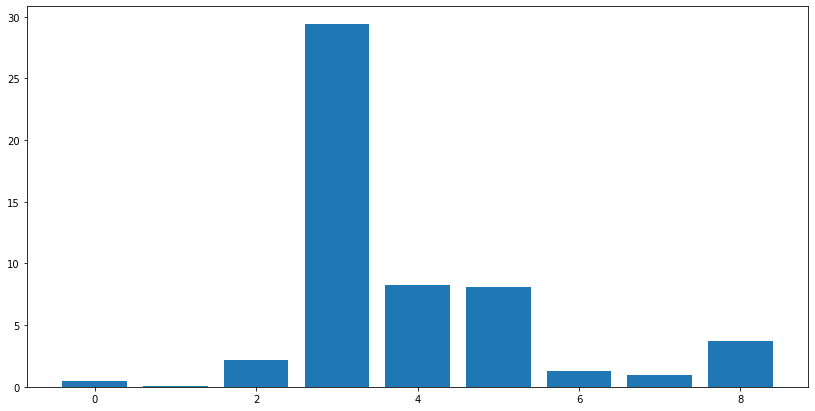

In [16]:
# plot the scores
plt.figure(figsize=(14,7))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In this case, we can see the scores are small and it is hard to get an idea from the number alone as to which features are more relevant. Perhaps features 3, 4, 5, and 8 are most relevant.

A bar chart of the feature importance scores for each input feature is created. This clearly shows that feature 3 might be the most relevant (according to chi-squared) and that perhaps four of the nine input features are the most relevant. We could set k=4 When configuring the SelectKBest to select these top four features.

## Classification model built with all features (baseline)

There are many different techniques for scoring features and selecting features based on scores; how do you know which one to use? A robust approach is to evaluate models using different feature selection methods (and numbers of features) and select the method that results in a model with the best performance.

In this section, we will evaluate a Logistic Regression model with all features compared to a model built from features selected by chi-squared and those features selected via mutual information.

Logistic regression is a good model for testing feature selection methods as it can perform better if irrelevant features are removed from the model. As a first step, we will evaluate a LogisticRegression model using all the available features. The model is fit on the training dataset and evaluated on the test dataset.

In [17]:
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_enc, y_train_enc)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
# evaluate the model
yhat = model.predict(X_test_enc)

In [19]:
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 75.79


In this case, we can see that the model achieves a classification accuracy of about 75%.

We would prefer to use a subset of features that achieves a classification accuracy that is as good or better than this.

## Classification model built with Chi-Squared features

We can use the chi-squared test to score the features and select the four most relevant features.

The select_features() function below is updated to achieve this.

In [20]:
# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k=4)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs

In [21]:
# feature selection
X_train_fs, X_test_fs = select_features(X_train_enc, y_train_enc, X_test_enc)

In [22]:
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train_enc)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# evaluate the model
yhat = model.predict(X_test_fs)

In [24]:
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 74.74


Running the example reports the performance of the model on just four of the nine input features selected using the chi-squared statistic.
In this case, we see that the model achieved an accuracy of about 74%, a slight drop in performance.

It is possible that some of the features removed are, in fact, adding value directly or in concert with the selected features.

At this stage, we would probably prefer to use all of the input features.

To be sure that the effect is real, it would be a good idea to repeat each experiment multiple times and compare the mean performance. It may also be a good idea to explore using k-fold cross-validation instead of a simple train/test split.